<a href="https://colab.research.google.com/github/hyomee2/scooter-parking-detector/blob/main/models/mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## 1. tensorflow 설치

In [ ]:
!pip install tensorflow

In [ ]:
import os
import shutil
import random
from math import floor

# 수정된 경로: 모두 Google Drive 내에서 작업
original_base = '/content/gdrive/MyDrive/dataset/cnn'
combined_temp = '/content/gdrive/MyDrive/dataset/cnn_2stages/_temp_combined'
new_base = '/content/gdrive/MyDrive/dataset/cnn_2stages'

splits = ["train", "val", "test"]
class_names = ['improper', 'proper', 'noise']
random.seed(42)

# cnn 데이터셋 통합 후 재분할 준비
# combined_temp 폴더 초기화 및 생성
if os.path.exists(combined_temp):
    shutil.rmtree(combined_temp)
os.makedirs(combined_temp, exist_ok=True)

for cls in class_names:
    os.makedirs(os.path.join(combined_temp, cls), exist_ok=True)
    for split in splits:
        src = os.path.join(original_base, split, cls)
        if os.path.exists(src):
            for f in os.listdir(src):
                src_path = os.path.join(src, f)
                if os.path.isfile(src_path):
                    # 원본 split 정보를 파일명에 붙여서 저장 (ex: train_abc.jpg)
                    shutil.copy(src_path, os.path.join(combined_temp, cls, f"{split}_{f}"))

print("✅ CNN 데이터셋 통합 완료!")

# 재분할 및 stage별 폴더 생성 함수
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def split_and_copy(src_dir, dst_map, ratios):
    files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
    random.shuffle(files)
    total = len(files)
    train_end = floor(ratios[0] * total)
    val_end = train_end + floor(ratios[1] * total)

    for i, phase in enumerate(['train', 'val', 'test']):
        phase_files = files[:train_end] if phase == 'train' else \
                      files[train_end:val_end] if phase == 'val' else \
                      files[val_end:]
        dst_dir = dst_map[phase]
        ensure_dir(dst_dir)
        for fname in phase_files:
            shutil.copy(os.path.join(src_dir, fname), os.path.join(dst_dir, fname))

# stage1 / stage2 클래스 매핑
stage1_map = {
    'noise': '0_no_kickboard',
    'improper': '1_has_kickboard',
    'proper': '1_has_kickboard'
}

stage2_map = {
    'improper': '0_improper',
    'proper': '2_proper'
}

# stage별 분할 및 저장
for cls in class_names:
    src_dir = os.path.join(combined_temp, cls)

    # Stage 1 (noise 포함)
    dst_stage1 = {
        'train': os.path.join(new_base, 'stage1', 'train', stage1_map[cls]),
        'val': os.path.join(new_base, 'stage1', 'val', stage1_map[cls]),
        'test': os.path.join(new_base, 'stage1', 'test', stage1_map[cls])
    }
    split_and_copy(src_dir, dst_stage1, ratios=(0.8, 0.1, 0.1))

    # Stage 2 (noise 제외)
    if cls != 'noise':
        dst_stage2 = {
            'train': os.path.join(new_base, 'stage2', 'train', stage2_map[cls]),
            'val': os.path.join(new_base, 'stage2', 'val', stage2_map[cls]),
            'test': os.path.join(new_base, 'stage2', 'test', stage2_map[cls])
        }
        split_and_copy(src_dir, dst_stage2, ratios=(0.8, 0.1, 0.1))

print("✅ stage1, stage2 데이터셋 분할 및 생성 완료!")

✅ Mobilenet 데이터셋 통합 완료!
✅ stage1, stage2 데이터셋 분할 및 생성 완료!


## 2. 이상 이미지 제거

In [ ]:
import os

def clean_dataset(directory):
    valid_exts = ['.jpg', '.jpeg', '.png']
    removed_files = []

    for root, _, files in os.walk(directory):
        for fname in files:
            ext = os.path.splitext(fname)[-1].lower()
            if ext not in valid_exts:
                file_path = os.path.join(root, fname)
                removed_files.append(file_path)
                os.remove(file_path)

    return removed_files

# 데이터셋 경로 정리
removed = clean_dataset('/content/gdrive/MyDrive/cnn_2stages')
print(f"✅ 삭제된 비이미지 파일 개수: {len(removed)}")


✅ 삭제된 비이미지 파일 개수: 0


In [ ]:
from PIL import Image

def clean_corrupted_images(directory):
    corrupted = []
    for root, _, files in os.walk(directory):
        for fname in files:
            ext = os.path.splitext(fname)[-1].lower()
            if ext in ['.jpg', '.jpeg', '.png']:
                fpath = os.path.join(root, fname)
                try:
                    img = Image.open(fpath)
                    img.verify()  # 파일이 진짜 이미지인지 검사
                except Exception:
                    corrupted.append(fpath)
                    os.remove(fpath)
    return corrupted

# 실제 이미지 열어서 검사
bad_files = clean_corrupted_images('/content/gdrive/MyDrive/cnn_2stages')
print(f"🧹 삭제된 손상된 이미지 파일 개수: {len(bad_files)}")


🧹 삭제된 손상된 이미지 파일 개수: 0


## 3. 모델 학습

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC
import os
import numpy as np

# ✅ 경로 설정
base_path = '/content/gdrive/MyDrive/dataset/cnn_2stages'
stage1_train = os.path.join(base_path, 'stage1', 'train')
stage1_val = os.path.join(base_path, 'stage1', 'val')
stage2_train = os.path.join(base_path, 'stage2', 'train')
stage2_val = os.path.join(base_path, 'stage2', 'val')

# ✅ 데이터 증강 설정
datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

# ✅ Stage 1: 킥보드 유무 이진 분류
train_gen_1 = datagen.flow_from_directory(stage1_train, target_size=(224, 224), batch_size=32, class_mode='binary')
val_gen_1 = val_datagen.flow_from_directory(stage1_val, target_size=(224, 224), batch_size=32, class_mode='binary')

base_model_1 = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
x1 = GlobalAveragePooling2D()(base_model_1.output)
out1 = Dense(1, activation='sigmoid')(x1)
model_1 = Model(inputs=base_model_1.input, outputs=out1)

for layer in base_model_1.layers[:-60]:
    layer.trainable = False

model_1.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=[AUC(name='auc')])

callbacks_1 = [
    EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, mode='max'),
    ModelCheckpoint('/content/gdrive/MyDrive/mobilenet/best_stage1_mobilenetv2.h5',
                    monitor='val_auc', save_best_only=True, mode='max')
]

print("\n🔹 Stage 1 학습 시작")
history_1 = model_1.fit(train_gen_1, validation_data=val_gen_1, epochs=50, callbacks=callbacks_1)


# ✅ 경로 설정
base_path = '/content/gdrive/MyDrive/dataset/cnn_2stages'
stage2_train = os.path.join(base_path, 'stage2', 'train')
stage2_val = os.path.join(base_path, 'stage2', 'val')

# ✅ 데이터 증강 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

# ✅ 데이터 로딩
train_gen_2 = train_datagen.flow_from_directory(
    stage2_train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # one-hot 인코딩
    shuffle=True
)
val_gen_2 = val_datagen.flow_from_directory(
    stage2_val,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ✅ 클래스 가중치 설정
class_weight_2 = {
    0: 10.0,  # improper
    1: 1.0    # proper
}

# ✅ 모델 구성
base_model_2 = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
x = GlobalAveragePooling2D()(base_model_2.output)
out = Dense(2, activation='softmax')(x)
model_2 = Model(inputs=base_model_2.input, outputs=out)

# ✅ 마지막 60개 레이어만 fine-tuning
for layer in base_model_2.layers[:-60]:
    layer.trainable = False
for layer in base_model_2.layers[-60:]:
    layer.trainable = True

# ✅ 컴파일
model_2.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=[AUC(name='auc')]
)

# ✅ 콜백 설정
callbacks_2 = [
    EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, mode='max'),
    ModelCheckpoint(
        '/content/gdrive/MyDrive/mobilenet/best_stage2_mobilenetv2_focused_improper.h5',
        monitor='val_auc', save_best_only=True, mode='max'
    )
]

# ✅ 학습
print("\n🔹 Stage 2 학습 시작")
history_2 = model_2.fit(train_gen_2,
    validation_data=val_gen_2,
    epochs=50,
    class_weight=class_weight_2,
    callbacks=callbacks_2
)



Found 871 images belonging to 2 classes.
Found 108 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔹 Stage 1 학습 시작


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - auc: 0.5793 - loss: 0.6663

28/28 ━━━━━━━━━━━━━━━━━━━━ 342s 11s/step - auc: 0.5819 - loss: 0.6651 - val_auc: 0.7907 - val_loss: 0.5402 - learning_rate: 1.0000e-05
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - auc: 0.9122 - loss: 0.4867

28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 825ms/step - auc: 0.9121 - loss: 0.4859 - val_auc: 0.8935 - val_loss: 0.5458 - learning_rate: 1.0000e-05
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - auc: 0.9551 - loss: 0.3637

28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 812ms/step - auc: 0.9552 - loss: 0.3626 - val_auc: 0.9362 - val_loss: 0.6343 - learning_rate: 1.0000e-05
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - auc: 0.9796 - loss: 0.2648

28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 774ms/step - auc: 0.9796 - loss: 0.2641 - val_auc: 0.9659 - val_loss: 0.7247 - learning_rate: 1.0000e-05
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - auc: 0.9864 - loss: 0.2011

28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 795ms/step - auc: 0.9866 - loss: 0.2007 - val_auc: 0.9785 - val_loss: 0.8026 - learning_rate: 1.0000e-05
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - auc: 0.9901 - loss: 0.1699

28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 758ms/step - auc: 0.9902 - loss: 0.1697 - val_auc: 0.9849 - val_loss: 0.8235 - learning_rate: 1.0000e-05
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - auc: 0.9963 - loss: 0.1382

28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 846ms/step - auc: 0.9962 - loss: 0.1381 - val_auc: 0.9864 - val_loss: 0.7919 - learning_rate: 1.0000e-05
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - auc: 0.9986 - loss: 0.1140

28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 829ms/step - auc: 0.9985 - loss: 0.1140 - val_auc: 0.9878 - val_loss: 0.7936 - learning_rate: 1.0000e-05
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - auc: 0.9972 - loss: 0.1097

28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 834ms/step - auc: 0.9972 - loss: 0.1095 - val_auc: 0.9900 - val_loss: 0.7575 - learning_rate: 1.0000e-05
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - auc: 0.9984 - loss: 0.0973

28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 789ms/step - auc: 0.9984 - loss: 0.0973 - val_auc: 0.9925 - val_loss: 0.7440 - learning_rate: 1.0000e-05
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - auc: 0.9977 - loss: 0.0868

28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 832ms/step - auc: 0.9978 - loss: 0.0867 - val_auc: 0.9943 - val_loss: 0.7092 - learning_rate: 1.0000e-05
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 788ms/step - auc: 0.9991 - loss: 0.0757 - val_auc: 0.9943 - val_loss: 0.7042 - learning_rate: 1.0000e-05
Epoch 13/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 722ms/step - auc: 0.9995 - loss: 0.0655 - val_auc: 0.9939 - val_loss: 0.6913 - learning_rate: 1.0000e-05
Epoch 14/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - auc: 0.9994 - loss: 0.0684

28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 808ms/step - auc: 0.9994 - loss: 0.0682 - val_auc: 0.9961 - val_loss: 0.6697 - learning_rate: 1.0000e-05
Epoch 15/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - auc: 0.9998 - loss: 0.0511

28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 843ms/step - auc: 0.9998 - loss: 0.0512 - val_auc: 0.9975 - val_loss: 0.6648 - learning_rate: 1.0000e-05
Epoch 16/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 784ms/step - auc: 0.9999 - loss: 0.0480 - val_auc: 0.9975 - val_loss: 0.6309 - learning_rate: 1.0000e-05
Epoch 17/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - auc: 0.9996 - loss: 0.0477

28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 802ms/step - auc: 0.9996 - loss: 0.0478 - val_auc: 0.9986 - val_loss: 0.6049 - learning_rate: 1.0000e-05
Epoch 18/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 799ms/step - auc: 0.9998 - loss: 0.0433 - val_auc: 0.9986 - val_loss: 0.5600 - learning_rate: 1.0000e-05
Epoch 19/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 754ms/step - auc: 1.0000 - loss: 0.0377 - val_auc: 0.9986 - val_loss: 0.5479 - learning_rate: 1.0000e-05
Epoch 20/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 753ms/step - auc: 1.0000 - loss: 0.0352 - val_auc: 0.9986 - val_loss: 0.5268 - learning_rate: 1.0000e-05
Epoch 21/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - auc: 1.0000 - loss: 0.0339

28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 795ms/step - auc: 1.0000 - loss: 0.0338 - val_auc: 0.9989 - val_loss: 0.4842 - learning_rate: 5.0000e-06
Epoch 22/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 744ms/step - auc: 1.0000 - loss: 0.0315 - val_auc: 0.9989 - val_loss: 0.4571 - learning_rate: 5.0000e-06
Epoch 23/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 779ms/step - auc: 0.9999 - loss: 0.0324 - val_auc: 0.9989 - val_loss: 0.4292 - learning_rate: 5.0000e-06
Epoch 24/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - auc: 1.0000 - loss: 0.0326

28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 774ms/step - auc: 1.0000 - loss: 0.0325 - val_auc: 0.9996 - val_loss: 0.4032 - learning_rate: 5.0000e-06
Epoch 25/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 767ms/step - auc: 1.0000 - loss: 0.0278 - val_auc: 0.9996 - val_loss: 0.3791 - learning_rate: 5.0000e-06
Epoch 26/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 722ms/step - auc: 1.0000 - loss: 0.0250 - val_auc: 0.9996 - val_loss: 0.3631 - learning_rate: 5.0000e-06
Epoch 27/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 768ms/step - auc: 1.0000 - loss: 0.0267 - val_auc: 0.9993 - val_loss: 0.3494 - learning_rate: 5.0000e-06
Epoch 28/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 779ms/step - auc: 1.0000 - loss: 0.0289 - val_auc: 0.9996 - val_loss: 0.3287 - learning_rate: 2.5000e-06
Epoch 29/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 727ms/step - auc: 1.0000 - loss: 0.0259 - val_auc: 0.9996 - val_loss: 0.3083 - learning_rate: 2.5000e-06
Found 751 images belonging to 2 classes.
Found 93 images belonging to 2 classes.

🔹 Stage 2 학습 시작
Epoch 1/50
24/24 ━━━━━━━━━

24/24 ━━━━━━━━━━━━━━━━━━━━ 286s 11s/step - auc: 0.3798 - loss: 2.1315 - val_auc: 0.4634 - val_loss: 0.9245 - learning_rate: 1.0000e-05
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - auc: 0.5292 - loss: 1.6559

24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 730ms/step - auc: 0.5286 - loss: 1.6531 - val_auc: 0.6472 - val_loss: 0.6867 - learning_rate: 1.0000e-05
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - auc: 0.5625 - loss: 1.3696

24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 749ms/step - auc: 0.5625 - loss: 1.3691 - val_auc: 0.7881 - val_loss: 0.5517 - learning_rate: 1.0000e-05
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - auc: 0.5916 - loss: 1.2526

24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 791ms/step - auc: 0.5923 - loss: 1.2498 - val_auc: 0.8784 - val_loss: 0.4572 - learning_rate: 1.0000e-05
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - auc: 0.6230 - loss: 1.1278

24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 754ms/step - auc: 0.6245 - loss: 1.1260 - val_auc: 0.9285 - val_loss: 0.3896 - learning_rate: 1.0000e-05
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - auc: 0.7374 - loss: 0.9658

24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 895ms/step - auc: 0.7362 - loss: 0.9660 - val_auc: 0.9561 - val_loss: 0.3417 - learning_rate: 1.0000e-05
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - auc: 0.7184 - loss: 0.9134

24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 764ms/step - auc: 0.7195 - loss: 0.9125 - val_auc: 0.9644 - val_loss: 0.3126 - learning_rate: 1.0000e-05
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - auc: 0.7562 - loss: 0.8678

24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 784ms/step - auc: 0.7576 - loss: 0.8666 - val_auc: 0.9703 - val_loss: 0.2894 - learning_rate: 1.0000e-05
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - auc: 0.8031 - loss: 0.7507

24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 744ms/step - auc: 0.8039 - loss: 0.7503 - val_auc: 0.9746 - val_loss: 0.2693 - learning_rate: 1.0000e-05
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - auc: 0.8614 - loss: 0.6786

24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 747ms/step - auc: 0.8612 - loss: 0.6793 - val_auc: 0.9788 - val_loss: 0.2506 - learning_rate: 1.0000e-05
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - auc: 0.8463 - loss: 0.6523

24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 764ms/step - auc: 0.8469 - loss: 0.6532 - val_auc: 0.9790 - val_loss: 0.2381 - learning_rate: 1.0000e-05
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - auc: 0.8778 - loss: 0.6291

24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 749ms/step - auc: 0.8782 - loss: 0.6280 - val_auc: 0.9793 - val_loss: 0.2259 - learning_rate: 1.0000e-05
Epoch 13/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 830ms/step - auc: 0.8876 - loss: 0.5845 - val_auc: 0.9783 - val_loss: 0.2170 - learning_rate: 1.0000e-05
Epoch 14/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 680ms/step - auc: 0.9130 - loss: 0.5247 - val_auc: 0.9783 - val_loss: 0.2118 - learning_rate: 1.0000e-05
Epoch 15/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 677ms/step - auc: 0.9318 - loss: 0.4632 - val_auc: 0.9773 - val_loss: 0.2103 - learning_rate: 1.0000e-05
Epoch 16/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 695ms/step - auc: 0.9460 - loss: 0.4770 - val_auc: 0.9778 - val_loss: 0.2070 - learning_rate: 5.0000e-06
Epoch 17/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 723ms/step - auc: 0.9609 - loss: 0.4618 - val_auc: 0.9792 - val_loss: 0.2026 - learning_rate: 5.0000e-06


## 4. 임계값 최적화

In [ ]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import os

# ✅ 경로 설정
val_dir = '/content/gdrive/MyDrive/dataset/cnn/val'
model_stage1_path = '/content/gdrive/MyDrive/mobilenet/best_stage1_mobilenetv2.h5'
model_stage2_path = '/content/gdrive/MyDrive/mobilenet/best_stage2_mobilenetv2_focused_improper.h5'
# ✅ 모델 불러오기
model_1 = load_model(model_stage1_path)
model_2 = load_model(model_stage2_path)

# ✅ 검증 데이터 로딩
datagen = ImageDataGenerator(rescale=1./255)

# 검증 데이터 제너레이터
val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# ✅ 클래스 매핑 정보 출력 (검증 데이터 기준)
label_map = val_gen.class_indices
inv_map = {v: k for k, v in label_map.items()}
print("\n✅ 클래스 매핑 (검증 데이터셋의 실제 클래스 인덱스):", inv_map)

# --- 임계값 최적화: 검증 데이터 사용 ---

# ✅ 전체 검증 이미지 및 라벨 수집
print("\n검증 데이터 수집 중...")
x_val_all, y_val_all = [], []
for i in range(len(val_gen)):
    x_batch, y_batch = val_gen[i]
    x_val_all.extend(x_batch)
    y_val_all.extend(y_batch)

x_val_all = np.array(x_val_all)
y_val_all = np.array(y_val_all)
y_val_true = np.argmax(y_val_all, axis=1) # One-hot encoded y_val_all을 단일 클래스 인덱스로 변환
print(f"총 검증 이미지 수: {len(x_val_all)}")


# ✅ Stage 1 예측 확률 (검증 데이터에 대해)
print("\nStage 1 예측 수행 중 (검증 데이터)...")

stage1_val_preds = model_1.predict(x_val_all, verbose=1)


# ✅ 임계값 최적화 (proper recall ≥ 0.85 조건하에 improper recall 최대화)
best_threshold = None
best_improper_recall = -1
best_val_preds_for_threshold = None # 최적 임계값에서의 검증 데이터 예측 결과 저장

thresholds = np.arange(0.01, 0.5, 0.01) # 0.01부터 0.49까지 0.01 간격으로
RECALL_MIN_PROPER = 0.85

print("\n🔍 Threshold 탐색 시작 (proper recall ≥ 0.85 조건 하에서 improper recall 최대화 - 검증 데이터 사용)")

for t in thresholds:
    # Stage 1 예측을 이진화: t보다 크면 1_kickboard, 아니면 0_no_kickboard
    stage1_val_binary = (stage1_val_preds > t).astype(int).flatten()

    # Stage 1에서 '1' (has_kickboard)으로 분류된 이미지의 인덱스
    stage2_val_indices = np.where(stage1_val_binary == 1)[0]
    x_val_stage2 = x_val_all[stage2_val_indices]

    # 최종 예측 결과 배열 초기화: 기본값은 Stage 1에서 0(no_kickboard)으로 분류된 'noise' (최종 클래스 인덱스: 1)
    final_val_preds = np.full_like(stage1_val_binary, fill_value=1)

    # Stage 2로 넘어갈 이미지가 있을 경우 Stage 2 모델 예측 수행
    if len(x_val_stage2) > 0:
        stage2_val_preds = model_2.predict(x_val_stage2, verbose=0)
        # Stage 2는 0:improper, 1:proper 입니다.
        stage2_val_classes = np.argmax(stage2_val_preds, axis=1) # Stage 2의 예측 클래스 (0 또는 1)

        # Stage 2 예측을 최종 3개 클래스 (0:improper, 1:noise, 2:proper)에 매핑
        # Stage 2가 0(improper)으로 예측하면 최종 0(improper)
        # Stage 2가 1(proper)으로 예측하면 최종 2(proper)
        final_val_preds[stage2_val_indices] = np.where(stage2_val_classes == 0, 0, 2)
    # else 블록은 위에 final_val_preds 초기화로 이미 처리됨: Stage 2로 넘어갈 이미지가 없으면 모두 noise(1)

    # 분류 리포트 생성 및 재현율 추출
    report = classification_report(y_val_true, final_val_preds, output_dict=True, zero_division=0)

    # 'proper'와 'improper' 클래스에 해당하는 재현율 추출
    # inv_map (0: improper, 1: noise, 2: proper)에 따라
    # proper는 '2', improper는 '0'
    proper_recall = report.get('2', {}).get('recall', 0.0) # proper (클래스 2)의 recall
    improper_recall = report.get('0', {}).get('recall', 0.0) # improper (클래스 0)의 recall

    if proper_recall >= RECALL_MIN_PROPER:
        print(f" - threshold {t:.2f}: proper recall = {proper_recall:.4f}, improper recall = {improper_recall:.4f}")
        if improper_recall > best_improper_recall:
            best_improper_recall = improper_recall
            best_threshold = t
            best_val_preds_for_threshold = final_val_preds.copy()

# ✅ 최적 임계값 결과 출력 (검증 데이터 기준)
print("\n--- 임계값 최적화 결과 ---")
if best_threshold is not None:
    print(f"\n✅ 최적 threshold (검증 데이터 기준): {best_threshold:.2f} (improper recall = {best_improper_recall:.4f}, proper recall ≥ {RECALL_MIN_PROPER:.2f})")
    print("\n✅ Classification Report (최적 임계값 적용된 검증 데이터 결과)")
    print(classification_report(y_val_true, best_val_preds_for_threshold, target_names=['improper', 'noise', 'proper'], zero_division=0))
    print("\n✅ Confusion Matrix (최적 임계값 적용된 검증 데이터 결과)")
    print(confusion_matrix(y_val_true, best_val_preds_for_threshold))

    # AUC 계산
    from tensorflow.keras.utils import to_categorical
    y_val_true_one_hot = to_categorical(y_val_true, num_classes=3)
    best_val_preds_for_threshold_one_hot = to_categorical(best_val_preds_for_threshold, num_classes=3)
    auc = roc_auc_score(y_val_true_one_hot, best_val_preds_for_threshold_one_hot, multi_class='ovr')
    print(f"\n✅ AUC (검증 데이터, macro): {auc:.4f}")

else:
    print(f"\n⚠️ proper recall ≥ {RECALL_MIN_PROPER:.2f}를 만족하는 threshold가 검증 데이터에서 없습니다.")

Found 109 images belonging to 3 classes.

✅ 클래스 매핑 (검증 데이터셋의 실제 클래스 인덱스): {0: 'improper', 1: 'noise', 2: 'proper'}

검증 데이터 수집 중...
총 검증 이미지 수: 109

Stage 1 예측 수행 중 (검증 데이터)...
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 991ms/step

🔍 Threshold 탐색 시작 (proper recall ≥ 0.85 조건 하에서 improper recall 최대화 - 검증 데이터 사용)
 - threshold 0.01: proper recall = 1.0000, improper recall = 0.7419
 - threshold 0.02: proper recall = 1.0000, improper recall = 0.7419
 - threshold 0.03: proper recall = 1.0000, improper recall = 0.7419
 - threshold 0.04: proper recall = 1.0000, improper recall = 0.7097
 - threshold 0.05: proper recall = 1.0000, improper recall = 0.7097
 - threshold 0.06: proper recall = 1.0000, improper recall = 0.7097
 - threshold 0.07: proper recall = 1.0000, improper recall = 0.7097
 - threshold 0.08: proper recall = 1.0000, improper recall = 0.7097
 - threshold 0.09: proper recall = 1.0000, improper recall = 0.7097
 - threshold 0.10: proper recall = 1.0000, improper recall = 0.7097
 - threshold 0.11: prope

## 5. 시각화

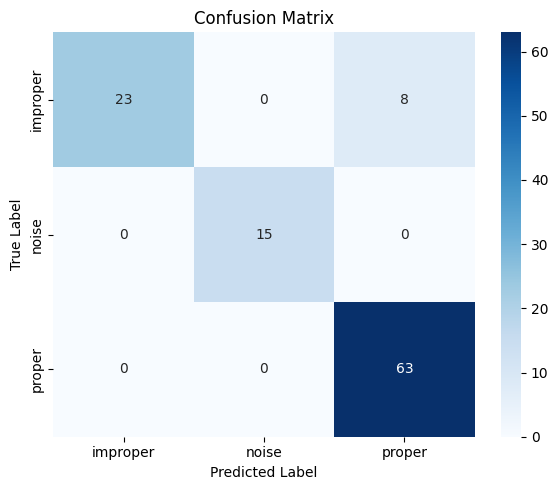

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# ✅ 클래스 이름
class_names = ['improper', 'noise', 'proper']

# ✅ 혼동행렬 정의 (직접 입력한 경우)
cm = np.array([[23 ,0,  8],
 [ 0, 15,  0],
 [ 0,  0, 63]])

# ✅ 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()